# <u><center>Hyper-Parameter optimization of Neural-Network-Models in algorithmic trading environments: a Python-based approach</center></u>

***Review-Version, January 2023, Dr. Andreas Horzella***

## Project abstract

The increasing impact of artificial intelligence (AI) applications on more and more aspects of life is obvious. Consequently, the financial sector has also been heavily involved in corresponding developments in recent years. In terms of trading financial instruments, neural networks and reinforcement learning (RL) agents are promising approaches for building an alpha-generating algorithmic trading system: experience and gut feeling of a human trader are replaced by a complex network of calculated input-output relations. These are multi-dimensional, multi-layered and generated from existing and emerging market data using Machine Learning (ML) algorithms. The result are models that can provide statistically based forecasts of future market developments.

In addition to the availability of high-quality data, the calibration of the model parameters represents a main factor influencing the forecast quality. This includes the design of the model itself, performed by the training process, as well as the adjustment of the hyper parameters in advance, both a mutual and ongoing process in a fast-moving financial market environment.

When it comes to the design of the hyper parameters, it is the responsibility of the developer to thoroughly orchestrate the interaction of all variables. The variety of possibilities here is huge and sometimes it is quite challenging and time consuming to come up with an appropriate solution. In fact, this configuration process represents one major, time-consuming effort while building a reliable forecast model. Hence it is crucial to have supporting tools at hand which reduce the vast variety of possible configurations to the most promising ones and thereby dramatically boil down the development time for new AI models.

Tools for hyper-parameter-optimization / hyper-tuning already do exist, but basically focus merely on the AI Model instead of optimizing the whole environment: prerequisite for optimizers like “Keras Tuner” is an already specified Model and a defined data- and feature set. Thus, the necessity for a dedicated, comprehensive tuning system for the design of AI-based algorithmic trading system is obvious. The purpose of this paper is to build a framework to facilitate the design of AI models for algorithmic trading systems in an automated manner, considering both model-/algorithmic parameters as well as data- and featureset related modifications.

## Approach, Methods, Techniques

The optimization approach consists of a Jupyter notebook, including two classes for data handling and model building. Those classes make it easier to streamline the following process and are additionally reusable for other cases.

First, the base parameters for the optimization and the tuning modes are set. Among those are the financial instrument, the granularity, timeframe and featureset. For demonstration purposes, a exemplary setup for the required parameters is included within the external configuration file "algo_config.cfg", which is read by using the configparser functionality. This file can be used to easily create user-specific scenarios.

The tuning mode defines which mathematical-statistical model shall be used for solving the optimization problem. The Search Spectrum, on the other hand, contains the determinants of the actual sequential neural network itself, in terms of number of units, number of layers, optimizer etc. Also these are specified in the configuration file.

As soon as data- and analysis-frameworks are defined, the main optimization loop initiates the tuning process by applying the selected tuning model to the defined data and search spectrum. At the end, the process provides an optimized model with the best hyperparameters and model variables which can be saved for further processing.

There are several different approaches to implement hyper parameter optimization for a keras-based neural network. Some of the most popular tools are:

- Keras Optimizer
- Scikit-Optimize
- Hyperopt
- Ray Tune
- Optuna
- Talos
- Spearmint

For the selection of the "right" tool, one should consider criteria like keras/tensorflow integration, performance and preferably low demand for adaptation of existing code. A good compromise in terms of complexity, usability and scalability is KERAS TUNER which is used here.

## Imports

First, the imports for the whole project require standard libraries like numpy, pandas and pylab. Additionally, the tpqoa module from The Python Quants for data import from OANDA data provider. Nevertheless, the exemplary process in this document will be based on fixed datafiles, containing minutely EUR-USD exchange rate for the timeframe 2021 January - 2022 September. The minutely data will then be resampled to hourly data. It is recommended to use a higher frequency for download from provider than afterwards used for analysis, since provider data sometimes may contain gaps which can be filled on a lower frequency level using the higher frequency source. Finally, tensorflow as well as keras and sklearn are imported, together with the keras tuner package which is the essential module for this thesis.

In [ ]:
# Preparation for Google Colab Environment

# Install Keras Tuner
%pip install keras_tuner

# Prepare GOOGLE COLAB execution
!git clone https://github.com/AHorzella/tpq_algo.git

In [1]:
import os
import sys
import numpy as np
import pandas as pd
from pylab import plt, mpl
import configparser
import pickle
import time
import json
import random
import tensorflow as tf
from tensorflow import keras

# Modules to be installed via "pip install keras-tuner":
import keras_tuner                              
from keras.layers import Dense, Flatten, Activation, Dropout
from keras.models import Sequential
from keras.regularizers import l1, l2
from sklearn.metrics import accuracy_score

# Ignore performance warning from pandas due to excessive pd dataframe handling
from warnings import simplefilter               
simplefilter(action="ignore", category=pd.errors.PerformanceWarning)

# Necessary to clear output from a specific jupyter notebook cell
from IPython.display import clear_output        

plt.style.use('seaborn')
mpl.rcParams['savefig.dpi'] = 300
mpl.rcParams['font.family'] = 'serif'
np.set_printoptions(suppress=True, precision=4)
os.environ['PYTHONHASHSEED'] = '0'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '5'

# Load basic configfile with important parameters for tuning process
model_config = configparser.ConfigParser()

# Activate one of the following versions A/B (Google Colab vs. local execution)

# VERSION A: execute from Google Colab
model_config.read('tpq_algo/algo_config.cfg')
sys.path.append("tpq_algo")

# VERSION B: execute local
# model_config.read('algo_config.cfg')

['algo_config.cfg']

## PARAMETERS: DATABASE

The database parameters include symbol, price type, start- and enddate and granularity as well as the featureset. All parameters are read from the config file "algo.config.cfg". This enables the creation of different, regularly used scenarios.

 Current features are: return, simple moving average, minimum- and maximum-values, momentum, volatility and average true range indicator. Additional features may be added by the user. 
 
 Furthermore, it can be defined:
- norm_select: use normalized data yes/no
- test_share and validation_share: divide dataset into train-, test- and validation-data
- lags: number of past periods to be used for neural network prognosis
- window: number of periods for feature calculation (e.g. moving average)
- tuning_mode and tuning_spectrum: scenario selection for tuning (currently 1, 2 or 3 each; details see below)

In [2]:
# Read data from configfile

configpath = model_config['general']['configpath']
symbol =  model_config['database']['symbol'].split()

price = model_config['database']['price']
startdate = model_config['database']['startdate']
enddate = model_config['database']['enddate']
api_granularity = model_config['database']['api_granularity']
granularity = model_config['database']['granularity']

norm_select = bool(model_config['database']['norm_select'])
test_share = float(model_config['database']['test_share'])
validation_share = float(model_config['database']['validation_share'])

featureset = model_config['database']['featureset'].split()
lags = json.loads(model_config['database']['lags'])
windows = json.loads(model_config['database']['windows'])

tuning_mode = int(model_config['tuningmode']['tuning_mode'])
tuning_spectrum = int(model_config['tuningmode']['tuning_spectrum'])

## PARAMETERS: KERAS TUNER TUNING MODE

 The KERAS Tuner parameters are divided into "Keras Tuner Mode" and "Keras Tuner Spectrum". To keep the model user friendly, both categories are wrapped into three typical scenarios each, which can be selected upfront via the variables "tuning_mode" and "tuning_spectrum". In simplest case, the user just selects the scenarios und works with them, or he can get into detail and modify the scenarios directly. The scenarios are designed to provide three typical tuning environments, from simple (variables=1) to complex (variables=3).

Keras Tuner offers three basic tuner classes for optimization. The selection of the tuning mode offers the corresponding choice between "Random Search", "Bayesian Optimization" and "Hyperband". All of them are based on the so-called "Grid", which contains all possible combinations of hyperparameters in a model. The Grid is n-dimensional with n equals the number of hyperparameters to be tuned. To test all those combinations in reality would not be efficient, and in most cases not feasible due to the required huge calculation power. Instead, the algorithms choose intelligently subsets of the Grid and incrementally follow a defined path of optimization. Main characteristics of each class are: 

- Random Search: from the "Grid" with all hyperparameter combinations, in each iteration a random subset is chosen and the result of the loss function is calculated to estimate the model performance. At the end, the combination of the best hyperparameters is returned. Note: by far not all possible combinations are tested, only as many iterations as defined in the setup.
- Bayesian Optimization: this algorithm focuses on the minimization problem of the loss function. In the contrary to the random search, the selection of the hyperparameters for the next step is not randomly but derived from the likelihood to get a better parameter combination compared to the previous step.
- Hyperband: this tuning class works similar to random search but does not apply full training cycles to obviously bad combinations of hyperparameters. To achieve this, the method is based on the explore-exploit concept. This means, in the first step promising hyperparameter combinations are gained by training those on a comparably low number of epochs. The best-performing candidates then are passed to the main cycle with the time-consuming calculation over all defined epochs. This significantly avoids wasting time and computing power.

Basically, each tuner class offers individual variables for customization, e.g. number of epochs, objective or other specific factors. These variables can be modified below in each tuner-class-related scenario. By default, they are set to a robust value and can be taken for the first steps as they are. If desired, those variables could also been transferred to the configuration file.

In [3]:
# For all tuning modes, the accuracy on the validation dataset is target

if tuning_mode == 1:
    ktuner = 'RandomSearch'
    t_search_epochs = 10
    t_model_fit_epochs = 10
    t_objective='val_accuracy'      
    r_max_trials = 10
    r_executions_per_trial = 2

if tuning_mode == 2:
    ktuner = 'BayesianOptimization'
    t_search_epochs = 10
    t_model_fit_epochs = 10
    t_objective = 'val_accuracy'
    b_max_trials = 5
    b_num_initial_points = 2
    b_alpha = 0.0001
    b_beta = 2.6

if tuning_mode == 3:
    ktuner = 'Hyperband'
    t_search_epochs = 10
    t_model_fit_epochs = 10
    t_objective='val_accuracy'
    h_max_epochs = 5
    h_factor = 3
    h_iterations = 1

## PARAMETERS: KERAS TUNER SEARCH SPECTRUM

After selection of the tuning class, several parameters regarding the neural network model itself have to be customized. Those are:
- number of layers of the model
- number of units of the model
- activation function
- learning rate
- dropout mode
- optimizer
- regulation mode
- loss function

Again, all listed variables are wrapped in three scenarios that either can be chosen one to one or individually modified. From 1 to 3, the scenarios get more complex and time consuming during calculation but should also get more reliable. For example, whereas in scenario 1 only a maximum of 3 layers will be used, in scenario 3 the number of layers can go up to 7.

In [4]:
if tuning_spectrum == 1:
    hidden_layers_min_val = 1
    hidden_layers_max_val = 3
    hidden_units_min_val = 32
    hidden_units_max_val = 256
    hidden_units_step_val = 32
    activation_val = ['relu']
    dropout_rate_val = [0.3]
    lr_min_val = 1e-4
    lr_max_val = 1e-2
    lr_sampling_val = 'log'
    optimizer_val =['rmsprop']
    reg_value_val = [0.001, 0.005, 0.01, 0.05, 0.1]
    reg_val = ['l1', 'l2']
    loss_funct_val = ['binary_crossentropy']

if tuning_spectrum == 2:
    hidden_layers_min_val = 1
    hidden_layers_max_val = 5
    hidden_units_min_val = 32
    hidden_units_max_val = 512
    hidden_units_step_val = 32
    activation_val = [
        'relu',
        'sigmoid',
        'linear'
        ]
    dropout_rate_val = [0.0, 0.3, 0.5]
    lr_min_val = 1e-4
    lr_max_val = 1e-2
    lr_sampling_val = 'log'
    optimizer_val =[
        'rmsprop',
        'adam'
        ]
    reg_value_val = [0.001, 0.005, 0.01, 0.05, 0.1]
    reg_val = ['l1', 'l2']
    loss_funct_val = [
        'binary_crossentropy',
        'mean_squared_error'
        ]

if tuning_spectrum == 3:
    hidden_layers_min_val = 1
    hidden_layers_max_val = 7
    hidden_units_min_val = 32
    hidden_units_max_val = 1024
    hidden_units_step_val = 32
    activation_val = [
        'relu',
        'tanh',
        'sigmoid',
        'softmax',
        'softplus', 
        'softsign',
        'selu',
        'elu',
        'exponential',
        'linear'
        ]
    dropout_rate_val = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5]
    lr_min_val = 1e-4
    lr_max_val = 1e-2
    lr_sampling_val = 'log'
    optimizer_val = [
        'sgd',
        'rmsprop',
        'adagrad',
        'adadelta',
        'adam',
        'nadam'
        ]
    reg_value_val = [0.001, 0.005, 0.01, 0.05, 0.1]
    reg_val = ['l1', 'l2']
    loss_funct_val = [
        'binary_crossentropy',
        'mean_squared_error',
        'mean_squared_logarithmic_error',
        'mean_absolute_error',
        'kl_divergence'
        ]

Two additional functions are required to initialize the seed and to apply weighting to the input dataset. Without weighting, the model probably will return biased output when used for imbalanced datasets. Both classes are taken from "The Python Quants" repository.

In [5]:
def set_seeds(seed=100):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)


def cw(df):
    c0, c1 = np.bincount(df['d'])
    w0 = (1 / c0) * (len(df)) / 2
    w1 = (1 / c1) * (len(df)) / 2
    return {0: w0, 1: w1}

## CLASS FOR DATA MANAGEMENT

The class DataEnvironment provides the basic functionality to load required financial instrument data. Once called, the "init"-procedure will load the defined data and prepare it for further processing. Following steps will be conducted:
- _get_data: required data is loaded local file.
For the purpose of this paper, a predefined file is used in order to guarantee replicability.
- _add_features: this function calculates the features based on that the AI algorithm will build the neural network model. From the pre-defined features a selection can be done via the featureset array in config file.
- _add_lags: the neural network model will do its forecast based on historical data. The number of lags defines the number of periods to look backwards. For all features this historical data will here be provided in the desired structure.
- _data_split: building a neural network model means training, validating and testing the model. The existing dataset will be separated into three parts to enable this procedure.
- _normalize: normalized data generally leads to better results in training a neural network. This function applies a mu/sigma-standardization to the dataset.

Additinally, two functions are added to gain details of the dataset and plot the data.

The whole class DataEnvironment is part of the external file "data_environment.py" and will just be imported here for further processings.

In [6]:
import data_environment as denv

After importing the DataEnvironment class, it can be initialized with the desired parameters. This generates the analysis datasets. Then data details can be shown and price data will be plotted in a chart.

In [7]:
envir = denv.DataEnvironment(
    symbol=symbol[0],
    api_granularity=api_granularity,
    granularity=granularity,
    window=20,
    lags=5,
    validation_share=validation_share,
    test_share=test_share,
    norm_select=norm_select,
    featureset=featureset,
    startdate=startdate,
    enddate=enddate,
    price=price
    )

In [8]:
# Show details of unprocessed raw data
envir.raw.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 276738 entries, 2022-01-02 22:03:00 to 2022-09-30 20:58:00
Data columns (total 6 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   o         276738 non-null  float64
 1   h         276738 non-null  float64
 2   l         276738 non-null  float64
 3   c         276738 non-null  float64
 4   volume    276738 non-null  int64  
 5   complete  276738 non-null  bool   
dtypes: bool(1), float64(4), int64(1)
memory usage: 12.9 MB


In [9]:
# Show unprocessed raw data in table format
envir.raw.head()

,o,h,l,c,volume,complete
time,,,,,,
2022-01-02 22:03:00,1.13725,1.13725,1.13725,1.13725,1,True
2022-01-02 22:06:00,1.13718,1.13718,1.13670,1.13670,4,True
2022-01-02 22:07:00,1.13675,1.13686,1.13670,1.13686,7,True
2022-01-02 22:10:00,1.13690,1.13725,1.13690,1.13725,3,True
2022-01-02 22:11:00,1.13732,1.13766,1.13727,1.13751,4,True


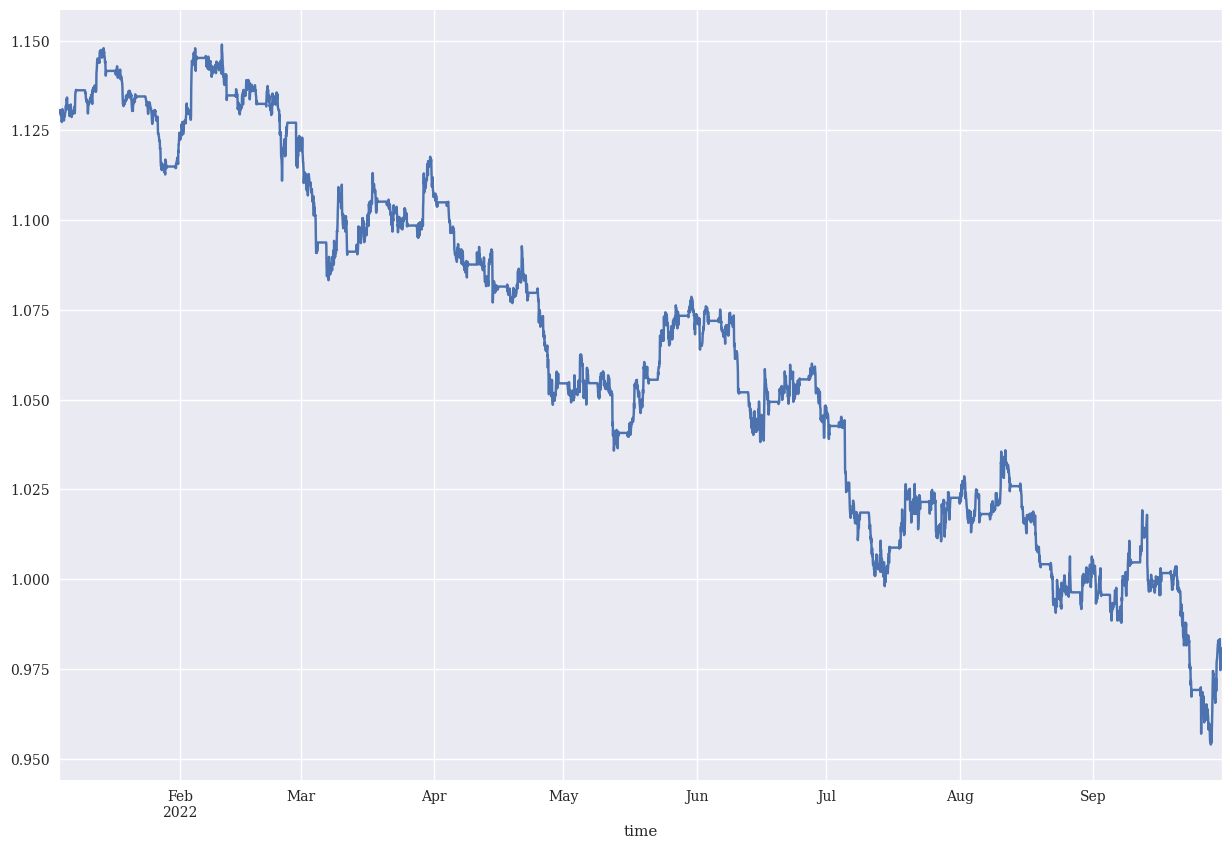

In [10]:
# Plot resampled price data
envir.plot_data()

## CLASS FOR MODEL BUILDING

Once the dataset has been created, KERAS Tuner needs a Hypermodel as prototype to be optimized. Same as for DataEnvironment, the Hypermodel is also wrapped in a class module and provides following functions:
- create_model: this is the main function to create the neural networks based on the received input. Since KERAS Tuner has to evaluate many different neural networks to finally come up with the best solution, this function has to be flexible in terms of varying the input values. To create the best model means to tune exactly those input parameters within given ranges of freedom. The create_model function on its part receives the allowed input ranges from the build function.
- build: the main task of the build function is to create the optimization ranges for the hyperparameters and pass them to the create_model function for further processing. Most important here is the "hp"-function which easily allows to define search spaces for the tuning algorithm.
- opt_wrapper / reg_wrapper: helper functions to create parameter ranges for optimizer and regularization.
- fit: create neural network model based on the selected hyper parameters

The whole class HyperModel is part of the external file "hypermodel.py" and will just be imported here for further processings.

In [11]:
import hypermodel as hypm

## MAIN OPTIMIZATION LOOP

The following loop represents the core code for the KERAS Tuner approach, orchestrating amongst others the model_create- and build-procedures. It basically iterates over possible (hyper-) parameter combinations in order to find the best solution that leads to the minimal value of the loss function which is the core of the neural network optimization process. 

In each loop, the DataEnvironment Class creates the dataset according to the given parameters. Then the Keras Tuner is initialized and the tuner.search procedure is started. This is the most time-consuming part of the tuning process and can take, depending on the complexity of the tuning setup, between some minutes and some hours. Each valid parameter combination is saved to the results table. At the end, the summary()-function shows details like layers, shapes and number of parameters for the best model.

Important note: a model is classified to be "valid", if the directions predicted are not only 100% in one direction. In a falling market for example a model would be successful, if it consequently forecasts short positions only. Such a model would loose all if the market turns up. Therefore, the target must be to train a model which is feasible for different market situations over time. And this is only the case if the model does predict ups as well as downs. Additionally, the accuracy of a valid model must be above the 50%-level, since this value represents the random choice approach.

In [12]:
results = []
ac_mem = 0

for symbol_sel in symbol:

    for l in lags:

        for w in windows:

            status = False
            
            envir = denv.DataEnvironment(
                symbol=symbol_sel,
                api_granularity=api_granularity,
                granularity=granularity,
                window=w,
                lags=l,
                validation_share=validation_share,
                test_share=test_share,
                norm_select=norm_select,
                featureset=featureset,
                startdate=startdate,
                enddate=enddate,
                price=price
                )

            if ktuner == 'RandomSearch':

                tuner = keras_tuner.RandomSearch(
                    hypermodel=hypm.TheHyperModel(envir, hidden_layers_min_val, hidden_layers_max_val,
                                                  hidden_units_min_val, hidden_units_max_val,
                                                  hidden_units_step_val, activation_val,
                                                  dropout_rate_val, lr_min_val, lr_max_val,
                                                  lr_sampling_val, optimizer_val,
                                                  reg_value_val, reg_val, loss_funct_val),
                    objective=t_objective,
                    max_trials=r_max_trials,
                    executions_per_trial=r_executions_per_trial,
                    seed=None,
                    hyperparameters=None,
                    tune_new_entries=True,
                    allow_new_entries=True,
                    overwrite = True,
                    directory='Datastore/my_dir',
                    project_name='tune_hypermodel'
                    )

            if ktuner == 'BayesianOptimization':

                tuner = keras_tuner.BayesianOptimization(
                    hypermodel=hypm.TheHyperModel(envir, hidden_layers_min_val, hidden_layers_max_val,
                                                  hidden_units_min_val, hidden_units_max_val,
                                                  hidden_units_step_val, activation_val,
                                                  dropout_rate_val, lr_min_val, lr_max_val,
                                                  lr_sampling_val, optimizer_val,
                                                  reg_value_val, reg_val, loss_funct_val),
                    objective=t_objective,
                    max_trials=b_max_trials,
                    num_initial_points=b_num_initial_points,
                    alpha=b_alpha,
                    beta=b_beta,
                    seed=None,
                    hyperparameters=None,
                    tune_new_entries=True,
                    allow_new_entries=True,
                    overwrite = True,
                    directory='Datastore/my_dir',
                    project_name='tune_hypermodel'
                    )
            
            if ktuner == 'Hyperband':

                tuner = keras_tuner.Hyperband(
                    hypermodel=hypm.TheHyperModel(envir, hidden_layers_min_val, hidden_layers_max_val,
                                                  hidden_units_min_val, hidden_units_max_val,
                                                  hidden_units_step_val, activation_val,
                                                  dropout_rate_val, lr_min_val, lr_max_val,
                                                  lr_sampling_val, optimizer_val,
                                                  reg_value_val, reg_val, loss_funct_val),
                    objective=t_objective,
                    max_epochs=h_max_epochs,
                    factor=h_factor,
                    hyperband_iterations=h_iterations,
                    seed=None,
                    hyperparameters=None,
                    tune_new_entries=True,
                    allow_new_entries=True,
                    overwrite = True,
                    directory='Datastore/my_dir',
                    project_name='tune_hypermodel'
                    )

            # Based on the environment defined above, the tuning process is started                        
            tuner.search(
                envir.train_[envir.cols],
                envir.train['d'],
                epochs=t_search_epochs,
                validation_data=(envir.validation_[envir.cols], envir.validation['d']),
                class_weight=cw(envir.train),
                verbose = False
                )
            
            # Retrain the model with best hyperparameters on combined train+validation dataset
            hypermodel=hypm.TheHyperModel(envir, hidden_layers_min_val, hidden_layers_max_val,
                                                  hidden_units_min_val, hidden_units_max_val,
                                                  hidden_units_step_val, activation_val,
                                                  dropout_rate_val, lr_min_val, lr_max_val,
                                                  lr_sampling_val, optimizer_val,
                                                  reg_value_val, reg_val, loss_funct_val)
            best_hp = tuner.get_best_hyperparameters()[0]
            model = hypermodel.build(best_hp)
            model_mem = model
            hist = hypermodel.fit(best_hp, model, envir.trainval[envir.cols], envir.trainval['d'],
                                  epochs=t_model_fit_epochs, class_weight=cw(envir.trainval))

            # Get model performance (accuracy)
            ls, ac = model.evaluate(envir.trainval[envir.cols], envir.trainval['d'])

            # Use current model for prediction
            envir.trainval['predresult'] = model.predict(envir.trainval[envir.cols])
            envir.trainval['pred'] = np.where(model.predict(envir.trainval[envir.cols]) > 0.5, 1, 0)
            directions = envir.trainval['pred'].value_counts().index.values
            preds = envir.trainval['pred'].value_counts().values

            # Calculate "real" result
            perform = sum(envir.trainval['r']*envir.trainval['pred'])/envir.trainval[symbol_sel][0]*100
            
            # Calulate ratio between 0 and 1 predictions
            if directions.size > 1:
                up = envir.trainval['pred'].value_counts()[1]
                down = envir.trainval['pred'].value_counts()[0]
                ratio = min(up, down)/max(up, down)
            
            # If valid solution: predictions in both directions and accuracy >50% and ratio 0/1 not closwe to 0
            if directions.size > 1 and ac > 0.5 and ratio>0.1:     
                status = True
            
                # Append valid results to dataframe
                results.append([status, symbol_sel, startdate, enddate, granularity,
                                perform, ac, directions, preds, ratio, featureset, l, w,
                                tuner.get_best_hyperparameters()[0]['layers'],
                                tuner.get_best_hyperparameters()[0]['units'],
                                tuner.get_best_hyperparameters()[0]['activation'],
                                tuner.get_best_hyperparameters()[0]['dropout'],
                                tuner.get_best_hyperparameters()[0]['drop_rate'],
                                tuner.get_best_hyperparameters()[0]['lr'],
                                tuner.get_best_hyperparameters()[0]['optimizer'],
                                tuner.get_best_hyperparameters()[0]['regularize'],
                                tuner.get_best_hyperparameters()[0]['reg_value'],
                                tuner.get_best_hyperparameters()[0]['type'],
                                tuner.get_best_hyperparameters()[0]['loss_funct']]
                                )
                
                if ac > ac_mem:                 # If current accuracy is greater than all accuracies so far ...
                    ac_mem = ac                 # ... save current accuracy as new best value ...
                    model_best = model_mem      # ... and save corresponding model as new best model

# Results table now is formatted as pd dataframe with appropriate column naming
finres = pd.DataFrame(
    results, columns=[
        'Valid', 'Symbol', 'Start',
        'End', 'Granularity', 'Performance',
        'Accuracy', 'Directions', 'Move',
        'Ratio', 'Featureset', 'Lags',
        'Window', 'Layers', 'Units',
        'Activation', 'Dropout', 'DropoutRate',
        'LR', 'Optimizer', 'Regularize',
        'RegValue', 'RegType', 'LossFunct']
        )

clear_output(wait=True)

# If at least one valid solution was found, print structure of best model
if len(results) >= 1:
    print(model_best.summary())
else:
    print('No valid solution found. Please change settings and restart.')

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_7 (Dense)             (None, 832)               125632    
                                                                 
 dense_8 (Dense)             (None, 832)               693056    
                                                                 
 dense_9 (Dense)             (None, 832)               693056    
                                                                 
 dense_10 (Dense)            (None, 832)               693056    
                                                                 
 dense_11 (Dense)            (None, 832)               693056    
                                                                 
 dense_12 (Dense)            (None, 832)               693056    
                                                                 
 dense_13 (Dense)            (None, 1)                

## RESULTS

After the tuning process, the results are shown in table format. First, all (valid) tuned models, and then the best model with its parameters.

In [13]:
# Show all valid models: main parameters in DataFrame-Format
finres

,Valid,Symbol,Start,End,Granularity,Performance,Accuracy,Directions,Move,Ratio,...,Units,Activation,Dropout,DropoutRate,LR,Optimizer,Regularize,RegValue,RegType,LossFunct
0,True,EUR_USD,2022-01-01,2022-10-01,1h,-4.801646,0.604898,"[1, 0]","[3575, 1611]",0.450629,...,192,selu,False,0.4,0.003243,adagrad,True,0.010,l2,binary_crossentropy
1,True,EUR_USD,2022-01-01,2022-10-01,1h,-2.767703,0.625169,"[1, 0]","[2929, 2252]",0.768863,...,832,linear,False,0.0,0.002883,nadam,False,0.005,l1,binary_crossentropy
2,True,EUR_USD,2022-01-01,2022-10-01,1h,-3.625923,0.620317,"[1, 0]","[2976, 2202]",0.739919,...,832,linear,False,0.0,0.002883,nadam,False,0.005,l1,binary_crossentropy


In [14]:
# Get parameters for the best model from whole dataframe and show them in Dataframe-Format as well
best_params = finres.loc[finres['Accuracy'] == max(finres['Accuracy'])]
best_params

,Valid,Symbol,Start,End,Granularity,Performance,Accuracy,Directions,Move,Ratio,...,Units,Activation,Dropout,DropoutRate,LR,Optimizer,Regularize,RegValue,RegType,LossFunct
1,True,EUR_USD,2022-01-01,2022-10-01,1h,-2.767703,0.625169,"[1, 0]","[2929, 2252]",0.768863,...,832,linear,False,0.0,0.002883,nadam,False,0.005,l1,binary_crossentropy


Now the best model including its dataset will be rebuild and evaluated. This is necessary because the best model is not necessarily the last one which has been calculated during tuning process and which still remains in memory.

In [15]:
envir_t = denv.DataEnvironment(
    symbol=best_params['Symbol'].values[0],
    api_granularity=api_granularity,
    granularity=granularity,
    window=int(best_params['Window']),
    lags=int(best_params['Lags']),
    validation_share=validation_share,
    test_share=test_share,
    norm_select=norm_select,
    featureset=best_params['Featureset'].values[0],
    startdate=startdate,
    enddate=enddate,
    price=price
    )

In [16]:
# Evaluate the best model (according to Keras Tuner) with specific datasets (in terms of features, lags and window)

if int(envir_t.train.size) > 0:
    print('Evaluation on train dataset:')
    model_best.evaluate(envir_t.train[envir_t.cols], envir_t.train['d'])
if int(envir_t.validation.size) > 0:
    print('Evaluation on validation dataset:')
    model_best.evaluate(envir_t.validation[envir_t.cols], envir_t.validation['d'])
if int(envir_t.trainval.size) > 0:
    print('Evaluation on combined train-/validation-dataset:')
    model_best.evaluate(envir_t.trainval[envir_t.cols], envir_t.trainval['d'])
if int(envir_t.test.size) > 0:
    print('Evaluation on test dataset:')
    model_best.evaluate(envir_t.test[envir_t.cols], envir_t.test['d'])
if int(envir_t.data.size) > 0:
    print('Evaluation on whole data dataset:')
    model_best.evaluate(envir_t.data[envir_t.cols], envir_t.data['d'])

Evaluation on train dataset:
142/142 [==============================] - 1s 6ms/step - loss: 0.6298 - accuracy: 0.6253
Evaluation on validation dataset:
21/21 [==============================] - 0s 11ms/step - loss: 0.6461 - accuracy: 0.6244
Evaluation on combined train-/validation-dataset:
162/162 [==============================] - 1s 6ms/step - loss: 0.6318 - accuracy: 0.6252
Evaluation on test dataset:
41/41 [==============================] - 0s 7ms/step - loss: 0.6550 - accuracy: 0.5991
Evaluation on whole data dataset:
203/203 [==============================] - 1s 6ms/step - loss: 0.6365 - accuracy: 0.6199


Once the model is applied to the whole dataset for prediction, the number of upward-predictions (1) and neutral/downward-predictions (0) can be evaluated.

In [17]:
envir_t.data['predresult'] = model_best.predict(envir_t.data[envir_t.cols])
envir_t.data['pred'] = np.where(model_best.predict(envir_t.data[envir_t.cols]) > 0.5, 1, 0)
envir_t.data['pred'].value_counts()

203/203 [==============================] - 0s 2ms/step


1    3741
0    2737
Name: pred, dtype: int64

## MODEL APPLICATION

Below it is shown how the final model can be applied to any other timeframe just by creating a new database instance and performing the model evaluation on this data. Even those results are promising since accuracy is still above 60%. This is remarkable since 2020 shows a bullish market, whereas the data for model training (2022) comes from a bearish market.

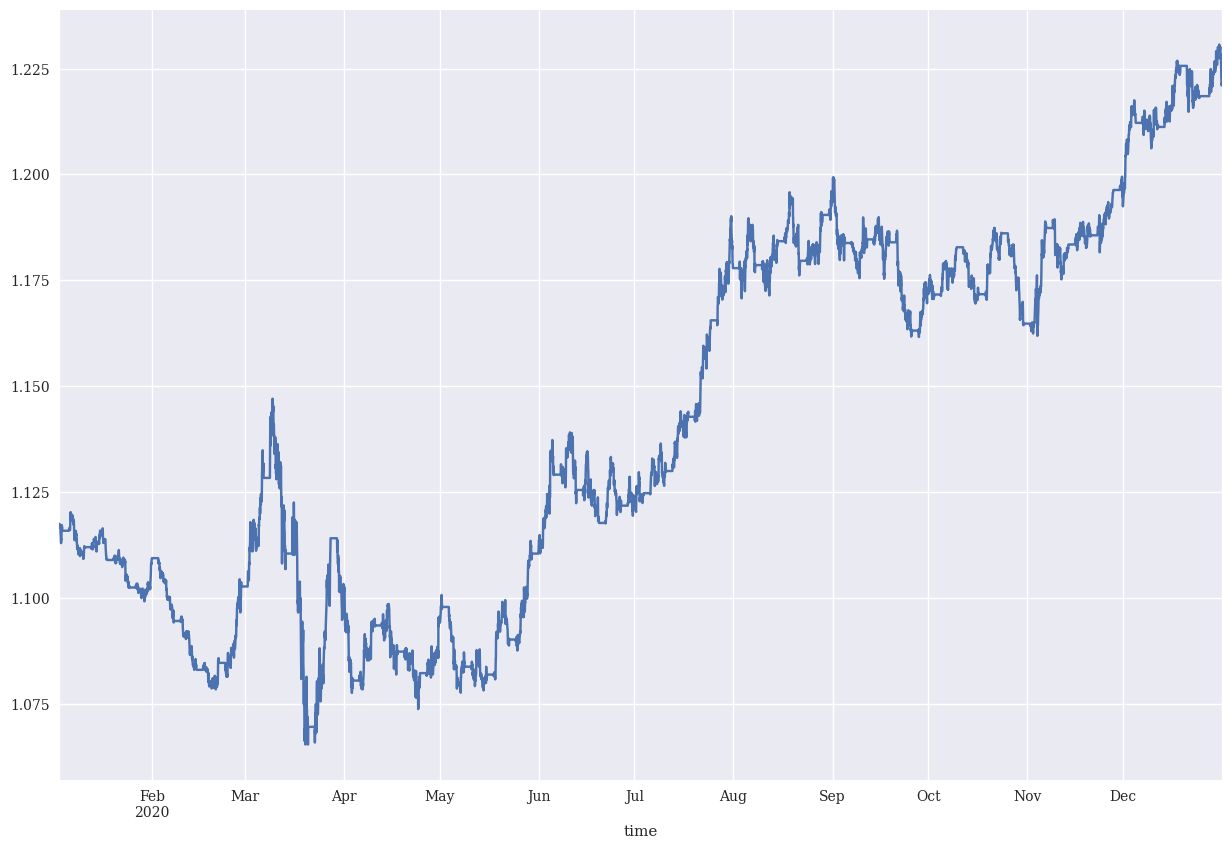

In [18]:
startdate = "2020-01-01"
enddate = "2021-01-01"
granularity = '1h'

envir_t = denv.DataEnvironment(
    symbol=best_params['Symbol'].values[0],
    api_granularity=api_granularity,
    granularity=granularity,
    window=int(best_params['Window']),
    lags=int(best_params['Lags']),
    validation_share=validation_share,
    test_share=test_share,
    norm_select=norm_select,
    featureset=best_params['Featureset'].values[0],
    startdate=startdate,
    enddate=enddate,
    price=price
    )

envir_t.plot_data()

In [19]:
print('Evaluation on whole data dataset:')
model_best.evaluate(envir_t.data[envir_t.cols], envir_t.data['d'])

Evaluation on whole data dataset:
273/273 [==============================] - 2s 6ms/step - loss: 0.6259 - accuracy: 0.6250


[0.6259014010429382, 0.6249570846557617]

In [20]:
envir_t.data['predresult'] = model_best.predict(envir_t.data[envir_t.cols])
envir_t.data['pred'] = np.where(model_best.predict(envir_t.data[envir_t.cols]) > 0.5, 1, 0)
envir_t.data['pred'].value_counts()

273/273 [==============================] - 1s 2ms/step


1    5002
0    3733
Name: pred, dtype: int64

## SAVE TUNER AND MODEL

Since the tuning process typically is time consuming, the results should be saved for further processing. The model itself may be used for a live trading environment, the tuner setup may be required for analysis later on.

In [21]:
with open(f"Datastore/tuner_save.pkl", "wb") as f:
    pickle.dump(tuner, f)

model_best.save('Datastore/BestModel')
best_params.to_pickle('Datastore/bestparams.pkl')

# Save result history
try:
    resulthistory = pd.read_csv('Datastore/results.csv', index_col=0)
    newresulthistory = pd.concat([resulthistory, finres])
except:
    newresulthistory = finres
newresulthistory.to_csv('Datastore/results.csv')

INFO:tensorflow:Assets written to: Datastore/BestModel/assets


## LOAD TUNER AND MODEL

For the sake of completeness, the following code shows how to reload all data to the system after a reset.

In [22]:
# Load tuner object; all modules must be executed before;
# Pickle doesn't store info about how a class/object is constructed,
# and needs access to the class when unpickling
tuner = pickle.load(open('Datastore/tuner_save.pkl', 'rb'))
best_params = pd.read_pickle('Datastore/bestparams.pkl')
model_best = keras.models.load_model('Datastore/BestModel')

## CONCLUSION

The application of KERAS TUNER to a neural network optimization problem relieves burden from the developer significantly by heavily decreasing development time and calculation effort. The results consistently show accuracy rates above 60% for the example shown above, focusing on the EUR-USD exchange rate for the years 2021 and 2022.

In this approach, two main classes provide reusability and increase ease of use. These may be extracted to an external script to be imported for use.

Possible Extension:
- To further improve results, application of bagging could be one promising approach.
- Data like volume- and orderbook-information may improve the predictions.
- The prediction currently separates only between the two options up- and neutral/down. Prediction of all three options (up, down, neutral) may be implemented.